In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import jax.numpy as jnp
from jax import grad, jit, random, partial, lax

import context
from models.logistic_regression.logistic_regression_model import gen_data, loglikelihood, logprior, accuracy
from tuning.mamba import timed_sampler
from tuning.ksd import imq_KSD
from tuning.util import build_metric_curve_fn, get_mean_sd_ksd_curve
from util import wait_until_computed

from sgmcmcjax.kernels import build_sgld_kernel, build_sghmc_kernel, build_sgnht_kernel
from sgmcmcjax.kernels import build_sgldCV_kernel, build_sghmcCV_kernel, build_sgnhtCV_kernel


# Logistic regression

In [2]:


key = random.PRNGKey(42)
dim = 10
# Ndata = 100_000
Ndata = 1_000_000

theta_true, X, y_data = gen_data(key, dim, Ndata)

# testing and training data
num_train = int(Ndata*0.8)

X_train = X[:num_train]
X_test = X[num_train:]

y_train = y_data[:num_train]
y_test = y_data[num_train:]
print(X_train.shape, X_test.shape)
data = (X_train, y_train)


# batch_size = int(0.01*X.shape[0])
gridsearch_bs = int(0.1*X_train.shape[0])
centering_value = theta_true
key = random.PRNGKey(0)

dt_baseline = 1/Ndata

generating data, with N=1,000,000 and dim=10
(800000, 10) (200000, 10)


In [3]:
from sgmcmcjax.util import build_grad_log_post
from jax import vmap, jit

NUTS_stds = np.genfromtxt("outputs/LR_uncertainty_tests/NUTS_stds.txt")

def get_relative_error_LR(estimate, ground_truth=NUTS_stds):
    "compare to NUTS samples"
    return np.linalg.norm(estimate - ground_truth)/np.linalg.norm(ground_truth)

grad_log_post = build_grad_log_post(loglikelihood, logprior, data)
batch_grad_log_post = jit(vmap(lambda x: grad_log_post(x, *data)))

def get_fb_grads_batches(samples, calc_batch_size):
    """
    Calculate the fullbatch gradients, but in batches
    """
    samples = jnp.array(samples)
    list_grads = []
    len_sgld = samples.shape[0]
    num_steps = int(np.ceil(len_sgld/calc_batch_size))
    for i in range(num_steps):
        new_grads = batch_grad_log_post(samples[i*calc_batch_size:(i+1)*calc_batch_size])
        wait_until_computed(new_grads)
        list_grads.append(new_grads)
    fb_grads = jnp.concatenate(list_grads, axis=0)
    return fb_grads

def get_ksd_LR(samples, thin_step):
#     grad_log_post = build_grad_log_post(loglikelihood, logprior, data)
#     batch_grad_log_post = jit(vmap(lambda x: grad_log_post(x, *data)))
    
    num_samples = len(samples)
    samples_array = jnp.array(samples[::thin_step])
#     fb_grads = batch_grad_log_post(samples_array)
    fb_grads = get_fb_grads_batches(samples_array, 500)
    return imq_KSD(samples_array, fb_grads)

def assess_LR_samples(samples, thin_step):
    print(f"assessing the samples. Num samples: {len(samples)}")
    ksd_est = get_ksd_LR(samples, thin_step)
    std_error = get_relative_error_LR(np.std(samples, axis=0))
    samples_array = jnp.array(samples[::thin_step])
    pred_acc = accuracy(samples_array, X_test, y_test)
    return ksd_est, pred_acc, std_error, len(samples)
    
def run_time_budget(key, time_budget, build_kernel, thin, dict_params, params_IC=theta_true):
    timed_sampler_factory = timed_sampler(build_kernel)
    my_timed_sampler = timed_sampler_factory(**dict_params)
    samples, _ = my_timed_sampler(key, time_budget, params_IC)
    return assess_LR_samples(samples, thin)



### build partial kernels

In [4]:
partial_build_sgld = lambda dt, batch_size: build_sgld_kernel(dt, loglikelihood, 
                                                              logprior, data, batch_size)
partial_build_sgldCV = lambda dt, batch_size: build_sgldCV_kernel(dt, loglikelihood, 
                                                    logprior, data, batch_size, centering_value)

partial_build_sghmc = lambda dt, L, batch_size: build_sghmc_kernel(dt, L, loglikelihood, 
                                                              logprior, data, batch_size)
partial_build_sghmcCV = lambda dt, L, batch_size: build_sghmcCV_kernel(dt, L, loglikelihood, 
                                                              logprior, data, batch_size, centering_value)

partial_build_sgnht = lambda dt, batch_size: build_sgnht_kernel(dt, loglikelihood, 
                                                              logprior, data, batch_size)
partial_build_sgnhtCV = lambda dt, batch_size: build_sgnhtCV_kernel(dt, loglikelihood, 
                                                              logprior, data, batch_size, centering_value)

# time_budget = 5
# thin = 5

time_budget = 20
thin = 20


# 1. A long run

- 1 million data points
- 20sec budget
- thin by 20

In [21]:
sh_params = {'batch_size': 800000, 'dt': 3.1622776e-06}
gridsearch_params = {'batch_size': gridsearch_bs, 'dt': 1e-6}
baseline_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}

print(run_time_budget(key, time_budget, partial_build_sgld, thin, sh_params))
print(run_time_budget(key, time_budget, partial_build_sgld, thin, gridsearch_params))
print(run_time_budget(key, time_budget, partial_build_sgld, thin, baseline_params))

assessing the samples. Num samples: 2291
(Buffer(62.434216, dtype=float32), DeviceArray(0.93895996, dtype=float32), 0.06656733684461966, 2291)
assessing the samples. Num samples: 6867
(DeviceArray(94.30054, dtype=float32), DeviceArray(0.93898, dtype=float32), 0.1801426881811909, 6867)
assessing the samples. Num samples: 6935
(DeviceArray(94.78978, dtype=float32), DeviceArray(0.938975, dtype=float32), 0.18194108912645127, 6935)


In [22]:
sh_params = {'batch_size': 800, 'dt': 3.1622776e-06}
gridsearch_params = {'batch_size': gridsearch_bs, 'dt': 1e-05}
baseline_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}

print(run_time_budget(key, time_budget, partial_build_sgldCV, thin, sh_params))
print(run_time_budget(key, time_budget, partial_build_sgldCV, thin, gridsearch_params))
print(run_time_budget(key, time_budget, partial_build_sgldCV, thin, baseline_params))

assessing the samples. Num samples: 105779
(DeviceArray(12.158579, dtype=float32), DeviceArray(0.93895495, dtype=float32), 0.011868206793966931, 105779)
assessing the samples. Num samples: 5809
(DeviceArray(38.842117, dtype=float32), DeviceArray(0.93895996, dtype=float32), 0.14004768914765875, 5809)
assessing the samples. Num samples: 5742
(DeviceArray(64.80522, dtype=float32), DeviceArray(0.93896997, dtype=float32), 0.15398081915622983, 5742)


In [23]:
sh_params = {'batch_size': 800, 'L': 5, 'dt': 3.1622776e-08}
gridsearch_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': 1e-07}
baseline_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': dt_baseline}

print(run_time_budget(key, time_budget, partial_build_sghmc, thin, sh_params))
print(run_time_budget(key, time_budget, partial_build_sghmc, thin, gridsearch_params))
print(run_time_budget(key, time_budget, partial_build_sghmc, thin, baseline_params))

assessing the samples. Num samples: 76168
(DeviceArray(62.38453, dtype=float32), DeviceArray(0.93896496, dtype=float32), 0.3431125534731983, 76168)
assessing the samples. Num samples: 871
(DeviceArray(142.46878, dtype=float32), DeviceArray(0.93895996, dtype=float32), 0.11776767166374653, 871)
assessing the samples. Num samples: 871
(Buffer(56724.36, dtype=float32), DeviceArray(0.926115, dtype=float32), 29.053134632074922, 871)


In [24]:
sh_params = {'batch_size': 80, 'L': 10, 'dt': 1e-07}
gridsearch_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': 3.1622776e-07}
baseline_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': dt_baseline}

print(run_time_budget(key, time_budget, partial_build_sghmcCV, thin, sh_params))
print(run_time_budget(key, time_budget, partial_build_sghmcCV, thin, gridsearch_params))
print(run_time_budget(key, time_budget, partial_build_sghmcCV, thin, baseline_params))

assessing the samples. Num samples: 104082
(DeviceArray(10.583215, dtype=float32), DeviceArray(0.93895495, dtype=float32), 0.07263925066728913, 104082)
assessing the samples. Num samples: 693
(Buffer(94.10962, dtype=float32), DeviceArray(0.93895495, dtype=float32), 0.059828882776049426, 693)
assessing the samples. Num samples: 695
(Buffer(54823.19, dtype=float32), DeviceArray(0.92651, dtype=float32), 29.357826104223406, 695)


In [25]:
sh_params = {'batch_size': 800000, 'dt': 3.1622776e-06}
gridsearch_params = {'batch_size': gridsearch_bs, 'dt': 3.1622776e-08}
baseline_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}

print(run_time_budget(key, time_budget, partial_build_sgnht, thin, sh_params))
print(run_time_budget(key, time_budget, partial_build_sgnht, thin, gridsearch_params))
print(run_time_budget(key, time_budget, partial_build_sgnht, thin, baseline_params))

assessing the samples. Num samples: 2239
(Buffer(15.827154, dtype=float32), DeviceArray(0.93895996, dtype=float32), 0.12468908397487347, 2239)
assessing the samples. Num samples: 8088
(DeviceArray(48.573803, dtype=float32), DeviceArray(0.93896496, dtype=float32), 0.22415345879112614, 8088)
assessing the samples. Num samples: 8126
(DeviceArray(68.63134, dtype=float32), DeviceArray(0.93895495, dtype=float32), 0.5378338042174073, 8126)


In [26]:
sh_params = {'batch_size': 8000, 'dt': 1e-06}
gridsearch_params = {'batch_size': gridsearch_bs, 'dt': 3.1622778e-05}
baseline_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}

print(run_time_budget(key, time_budget, partial_build_sgnhtCV, thin, sh_params))
print(run_time_budget(key, time_budget, partial_build_sgnhtCV, thin, gridsearch_params))
print(run_time_budget(key, time_budget, partial_build_sgnhtCV, thin, baseline_params))

assessing the samples. Num samples: 33668
(DeviceArray(4.257115, dtype=float32), DeviceArray(0.938945, dtype=float32), 0.016955398870115684, 33668)
assessing the samples. Num samples: 6635
(DeviceArray(10.399927, dtype=float32), DeviceArray(0.93895, dtype=float32), 0.12841904450700375, 6635)
assessing the samples. Num samples: 6525
(DeviceArray(9.712614, dtype=float32), DeviceArray(0.93895, dtype=float32), 0.15510750873367138, 6525)


# 2. KSD curves

### sgld

In [12]:
error_fn_ksd_curve = partial(get_ksd_LR, thin_step=20)
list_time_budget = [2, 4, 6, 8, 10]

In [27]:
dict_params = {'batch_size': 800000, 'dt': 3.1622776e-06}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgld, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgld_mamba, sd_ksd_curve_sgld_mamba = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 800000, 'dt': 3.1622776e-06}

Iteration 0/10
Budget: 2, num_samples = 245
Budget: 4, num_samples = 505
Budget: 6, num_samples = 764
Budget: 8, num_samples = 1010
Budget: 10, num_samples = 1276

Iteration 1/10
Budget: 2, num_samples = 256
Budget: 4, num_samples = 507
Budget: 6, num_samples = 756
Budget: 8, num_samples = 1012
Budget: 10, num_samples = 1267

Iteration 2/10
Budget: 2, num_samples = 256
Budget: 4, num_samples = 508
Budget: 6, num_samples = 769
Budget: 8, num_samples = 1020
Budget: 10, num_samples = 1283

Iteration 3/10
Budget: 2, num_samples = 257
Budget: 4, num_samples = 511
Budget: 6, num_samples = 770
Budget: 8, num_samples = 1009
Budget: 10, num_samples = 1137

Iteration 4/10
Budget: 2, num_samples = 225
Budget: 4, num_samples = 465
Budget: 6, num_samples = 718
Budget: 8, num_samples = 980
Budget: 10, num_samples = 1228

Iteration 5/10
Budget: 2, num_samples = 245
Budget: 4, num_samples = 417
Budget: 6, num_samples = 576
Budget: 8, num_samples

In [7]:
dict_params = {'batch_size': gridsearch_bs, 'dt': 1e-6}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgld, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgld_gridsearch, sd_ksd_curve_sgld_gridsearch = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 80000, 'dt': 1e-06}

Iteration 0/10
Budget: 2, num_samples = 688
Budget: 4, num_samples = 1647
Budget: 6, num_samples = 2471
Budget: 8, num_samples = 3293
Budget: 10, num_samples = 4106

Iteration 1/10
Budget: 2, num_samples = 686
Budget: 4, num_samples = 1376
Budget: 6, num_samples = 2455
Budget: 8, num_samples = 3282
Budget: 10, num_samples = 3425

Iteration 2/10
Budget: 2, num_samples = 819
Budget: 4, num_samples = 1638
Budget: 6, num_samples = 2455
Budget: 8, num_samples = 2737
Budget: 10, num_samples = 4111

Iteration 3/10
Budget: 2, num_samples = 683
Budget: 4, num_samples = 1369
Budget: 6, num_samples = 2047
Budget: 8, num_samples = 3286
Budget: 10, num_samples = 3425

Iteration 4/10
Budget: 2, num_samples = 682
Budget: 4, num_samples = 1373
Budget: 6, num_samples = 2051
Budget: 8, num_samples = 2741
Budget: 10, num_samples = 4100

Iteration 5/10
Budget: 2, num_samples = 682
Budget: 4, num_samples = 1296
Budget: 6, num_samples = 1944
Budget: 8, num_sam

In [14]:
dict_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgld, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgld_baseline, sd_ksd_curve_sgld_baseline = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 80000, 'dt': 1e-06}

Iteration 0/10
Budget: 2, num_samples = 666
Budget: 4, num_samples = 1595
Budget: 6, num_samples = 2416
Budget: 8, num_samples = 2743
Budget: 10, num_samples = 4109

Iteration 1/10
Budget: 2, num_samples = 667
Budget: 4, num_samples = 1346
Budget: 6, num_samples = 2425
Budget: 8, num_samples = 3231
Budget: 10, num_samples = 3970

Iteration 2/10
Budget: 2, num_samples = 669
Budget: 4, num_samples = 1327
Budget: 6, num_samples = 2437
Budget: 8, num_samples = 2779
Budget: 10, num_samples = 4112

Iteration 3/10
Budget: 2, num_samples = 684
Budget: 4, num_samples = 1648
Budget: 6, num_samples = 2473
Budget: 8, num_samples = 3238
Budget: 10, num_samples = 3377

Iteration 4/10
Budget: 2, num_samples = 816
Budget: 4, num_samples = 1646
Budget: 6, num_samples = 2085
Budget: 8, num_samples = 3197
Budget: 10, num_samples = 4054

Iteration 5/10
Budget: 2, num_samples = 683
Budget: 4, num_samples = 1343
Budget: 6, num_samples = 2026
Budget: 8, num_sam

### sgld-cv

In [28]:
dict_params = {'batch_size': 800, 'dt': 3.1622776e-06}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgldCV, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgldCV_mamba, sd_ksd_curve_sgldCV_mamba = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 800, 'dt': 3.1622776e-06}

Iteration 0/10
Budget: 2, num_samples = 9434
Budget: 4, num_samples = 13103
Budget: 6, num_samples = 21978
Budget: 8, num_samples = 36681
Budget: 10, num_samples = 52482

Iteration 1/10
Budget: 2, num_samples = 9934
Budget: 4, num_samples = 21032
Budget: 6, num_samples = 31512
Budget: 8, num_samples = 42161
Budget: 10, num_samples = 43343

Iteration 2/10
Budget: 2, num_samples = 9003
Budget: 4, num_samples = 21396
Budget: 6, num_samples = 32380
Budget: 8, num_samples = 41217
Budget: 10, num_samples = 53286

Iteration 3/10
Budget: 2, num_samples = 10424
Budget: 4, num_samples = 20407
Budget: 6, num_samples = 29987
Budget: 8, num_samples = 40069
Budget: 10, num_samples = 46079

Iteration 4/10
Budget: 2, num_samples = 9483
Budget: 4, num_samples = 21111
Budget: 6, num_samples = 30442
Budget: 8, num_samples = 41410
Budget: 10, num_samples = 51895

Iteration 5/10
Budget: 2, num_samples = 9228
Budget: 4, num_samples = 18436
Budget: 6, num

In [9]:
dict_params = {'batch_size': gridsearch_bs, 'dt': 1e-05}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgldCV, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgldCV_gridsearch, sd_ksd_curve_sgldCV_gridsearch = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 80000, 'dt': 1e-05}

Iteration 0/10
Budget: 2, num_samples = 576
Budget: 4, num_samples = 1173
Budget: 6, num_samples = 1762
Budget: 8, num_samples = 2343
Budget: 10, num_samples = 2938

Iteration 1/10
Budget: 2, num_samples = 586
Budget: 4, num_samples = 1177
Budget: 6, num_samples = 1760
Budget: 8, num_samples = 2340
Budget: 10, num_samples = 2928

Iteration 2/10
Budget: 2, num_samples = 582
Budget: 4, num_samples = 1164
Budget: 6, num_samples = 1756
Budget: 8, num_samples = 2340
Budget: 10, num_samples = 2926

Iteration 3/10
Budget: 2, num_samples = 585
Budget: 4, num_samples = 1161
Budget: 6, num_samples = 1751
Budget: 8, num_samples = 2344
Budget: 10, num_samples = 2916

Iteration 4/10
Budget: 2, num_samples = 582
Budget: 4, num_samples = 1174
Budget: 6, num_samples = 1751
Budget: 8, num_samples = 2336
Budget: 10, num_samples = 2923

Iteration 5/10
Budget: 2, num_samples = 582
Budget: 4, num_samples = 1171
Budget: 6, num_samples = 1759
Budget: 8, num_sam

In [15]:
dict_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgldCV, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgldCV_baseline, sd_ksd_curve_sgldCV_baseline = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 80000, 'dt': 1e-06}

Iteration 0/10
Budget: 2, num_samples = 567
Budget: 4, num_samples = 1142
Budget: 6, num_samples = 1623
Budget: 8, num_samples = 2295
Budget: 10, num_samples = 2875

Iteration 1/10
Budget: 2, num_samples = 559
Budget: 4, num_samples = 1106
Budget: 6, num_samples = 1651
Budget: 8, num_samples = 2173
Budget: 10, num_samples = 2715

Iteration 2/10
Budget: 2, num_samples = 516
Budget: 4, num_samples = 1088
Budget: 6, num_samples = 1666
Budget: 8, num_samples = 2283
Budget: 10, num_samples = 2688

Iteration 3/10
Budget: 2, num_samples = 547
Budget: 4, num_samples = 1088
Budget: 6, num_samples = 1647
Budget: 8, num_samples = 2208
Budget: 10, num_samples = 2796

Iteration 4/10
Budget: 2, num_samples = 575
Budget: 4, num_samples = 1143
Budget: 6, num_samples = 1686
Budget: 8, num_samples = 2254
Budget: 10, num_samples = 2776

Iteration 5/10
Budget: 2, num_samples = 541
Budget: 4, num_samples = 1076
Budget: 6, num_samples = 1613
Budget: 8, num_sam

### sghmc

In [29]:
dict_params = {'batch_size': 800, 'L': 5, 'dt': 3.1622776e-08}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmc, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmc_mamba, sd_ksd_curve_sghmc_mamba = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 800, 'L': 5, 'dt': 3.1622776e-08}

Iteration 0/10
Budget: 2, num_samples = 8109
Budget: 4, num_samples = 15668
Budget: 6, num_samples = 21876
Budget: 8, num_samples = 30107
Budget: 10, num_samples = 37709

Iteration 1/10
Budget: 2, num_samples = 7256
Budget: 4, num_samples = 15480
Budget: 6, num_samples = 22431
Budget: 8, num_samples = 30295
Budget: 10, num_samples = 32145

Iteration 2/10
Budget: 2, num_samples = 7057
Budget: 4, num_samples = 15451
Budget: 6, num_samples = 22512
Budget: 8, num_samples = 30278
Budget: 10, num_samples = 19293

Iteration 3/10
Budget: 2, num_samples = 6148
Budget: 4, num_samples = 14202
Budget: 6, num_samples = 22744
Budget: 8, num_samples = 28831
Budget: 10, num_samples = 27796

Iteration 4/10
Budget: 2, num_samples = 6732
Budget: 4, num_samples = 14292
Budget: 6, num_samples = 21737
Budget: 8, num_samples = 27412
Budget: 10, num_samples = 34663

Iteration 5/10
Budget: 2, num_samples = 6667
Budget: 4, num_samples = 13651
Budget:

In [11]:
dict_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': 1e-07}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmc, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmc_gridsearch, sd_ksd_curve_sghmc_gridsearch = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 80000, 'L': 10, 'dt': 1e-07}

Iteration 0/10
Budget: 2, num_samples = 86
Budget: 4, num_samples = 178
Budget: 6, num_samples = 260
Budget: 8, num_samples = 347
Budget: 10, num_samples = 445

Iteration 1/10
Budget: 2, num_samples = 89
Budget: 4, num_samples = 173
Budget: 6, num_samples = 260
Budget: 8, num_samples = 347
Budget: 10, num_samples = 436

Iteration 2/10
Budget: 2, num_samples = 88
Budget: 4, num_samples = 172
Budget: 6, num_samples = 260
Budget: 8, num_samples = 347
Budget: 10, num_samples = 433

Iteration 3/10
Budget: 2, num_samples = 86
Budget: 4, num_samples = 173
Budget: 6, num_samples = 260
Budget: 8, num_samples = 348
Budget: 10, num_samples = 432

Iteration 4/10
Budget: 2, num_samples = 86
Budget: 4, num_samples = 172
Budget: 6, num_samples = 259
Budget: 8, num_samples = 350
Budget: 10, num_samples = 433

Iteration 5/10
Budget: 2, num_samples = 86
Budget: 4, num_samples = 174
Budget: 6, num_samples = 260
Budget: 8, num_samples = 346
Budget: 

In [16]:
dict_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': dt_baseline}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmc, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmc_baseline, sd_ksd_curve_sghmc_baseline = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 80000, 'L': 10, 'dt': 1e-06}

Iteration 0/10
Budget: 2, num_samples = 89
Budget: 4, num_samples = 179
Budget: 6, num_samples = 268
Budget: 8, num_samples = 358
Budget: 10, num_samples = 448

Iteration 1/10
Budget: 2, num_samples = 90
Budget: 4, num_samples = 175
Budget: 6, num_samples = 262
Budget: 8, num_samples = 349
Budget: 10, num_samples = 436

Iteration 2/10
Budget: 2, num_samples = 90
Budget: 4, num_samples = 175
Budget: 6, num_samples = 262
Budget: 8, num_samples = 349
Budget: 10, num_samples = 436

Iteration 3/10
Budget: 2, num_samples = 88
Budget: 4, num_samples = 168
Budget: 6, num_samples = 259
Budget: 8, num_samples = 351
Budget: 10, num_samples = 425

Iteration 4/10
Budget: 2, num_samples = 85
Budget: 4, num_samples = 170
Budget: 6, num_samples = 241
Budget: 8, num_samples = 334
Budget: 10, num_samples = 429

Iteration 5/10
Budget: 2, num_samples = 84
Budget: 4, num_samples = 171
Budget: 6, num_samples = 258
Budget: 8, num_samples = 343
Budget: 

### sghmc-CV

In [30]:
dict_params = {'batch_size': 80, 'L': 10, 'dt': 1e-07}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmcCV, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmcCV_mamba, sd_ksd_curve_sghmcCV_mamba = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 80, 'L': 10, 'dt': 1e-07}

Iteration 0/10
Budget: 2, num_samples = 8736
Budget: 4, num_samples = 16324
Budget: 6, num_samples = 22879
Budget: 8, num_samples = 31760
Budget: 10, num_samples = 38814

Iteration 1/10
Budget: 2, num_samples = 7394
Budget: 4, num_samples = 14786
Budget: 6, num_samples = 23577
Budget: 8, num_samples = 27920
Budget: 10, num_samples = 21538

Iteration 2/10
Budget: 2, num_samples = 7815
Budget: 4, num_samples = 17092
Budget: 6, num_samples = 24631
Budget: 8, num_samples = 32933
Budget: 10, num_samples = 41807

Iteration 3/10
Budget: 2, num_samples = 6860
Budget: 4, num_samples = 14767
Budget: 6, num_samples = 21922
Budget: 8, num_samples = 14239
Budget: 10, num_samples = 30203

Iteration 4/10
Budget: 2, num_samples = 8844
Budget: 4, num_samples = 18522
Budget: 6, num_samples = 25919
Budget: 8, num_samples = 35012
Budget: 10, num_samples = 44599

Iteration 5/10
Budget: 2, num_samples = 8472
Budget: 4, num_samples = 18284
Budget: 6, num_

In [13]:
dict_params =  {'batch_size': gridsearch_bs, 'L': 10, 'dt': 3.1622776e-07}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmcCV, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmcCV_gridsearch, sd_ksd_curve_sghmcCV_gridsearch = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 80000, 'L': 10, 'dt': 3.1622776e-07}

Iteration 0/10
Budget: 2, num_samples = 69
Budget: 4, num_samples = 141
Budget: 6, num_samples = 213
Budget: 8, num_samples = 283
Budget: 10, num_samples = 349

Iteration 1/10
Budget: 2, num_samples = 70
Budget: 4, num_samples = 138
Budget: 6, num_samples = 210
Budget: 8, num_samples = 278
Budget: 10, num_samples = 347

Iteration 2/10
Budget: 2, num_samples = 68
Budget: 4, num_samples = 140
Budget: 6, num_samples = 208
Budget: 8, num_samples = 278
Budget: 10, num_samples = 350

Iteration 3/10
Budget: 2, num_samples = 68
Budget: 4, num_samples = 139
Budget: 6, num_samples = 209
Budget: 8, num_samples = 279
Budget: 10, num_samples = 349

Iteration 4/10
Budget: 2, num_samples = 69
Budget: 4, num_samples = 138
Budget: 6, num_samples = 208
Budget: 8, num_samples = 277
Budget: 10, num_samples = 346

Iteration 5/10
Budget: 2, num_samples = 69
Budget: 4, num_samples = 139
Budget: 6, num_samples = 209
Budget: 8, num_samples = 280


In [17]:
dict_params =  {'batch_size': gridsearch_bs, 'L': 10, 'dt': dt_baseline}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmcCV, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmcCV_baseline, sd_ksd_curve_sghmcCV_baseline = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 80000, 'L': 10, 'dt': 1e-06}

Iteration 0/10
Budget: 2, num_samples = 65
Budget: 4, num_samples = 130
Budget: 6, num_samples = 194
Budget: 8, num_samples = 261
Budget: 10, num_samples = 323

Iteration 1/10
Budget: 2, num_samples = 65
Budget: 4, num_samples = 124
Budget: 6, num_samples = 155
Budget: 8, num_samples = 255
Budget: 10, num_samples = 319

Iteration 2/10
Budget: 2, num_samples = 69
Budget: 4, num_samples = 139
Budget: 6, num_samples = 209
Budget: 8, num_samples = 278
Budget: 10, num_samples = 348

Iteration 3/10
Budget: 2, num_samples = 71
Budget: 4, num_samples = 139
Budget: 6, num_samples = 209
Budget: 8, num_samples = 277
Budget: 10, num_samples = 348

Iteration 4/10
Budget: 2, num_samples = 71
Budget: 4, num_samples = 139
Budget: 6, num_samples = 208
Budget: 8, num_samples = 277
Budget: 10, num_samples = 348

Iteration 5/10
Budget: 2, num_samples = 71
Budget: 4, num_samples = 134
Budget: 6, num_samples = 210
Budget: 8, num_samples = 278
Budget: 

### sgnht

In [31]:
dict_params = {'batch_size': 800000, 'dt': 3.1622776e-06}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnht, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnht_mamba, sd_ksd_curve_sgnht_mamba = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 800000, 'dt': 3.1622776e-06}

Iteration 0/10
Budget: 2, num_samples = 226
Budget: 4, num_samples = 479
Budget: 6, num_samples = 735
Budget: 8, num_samples = 967
Budget: 10, num_samples = 1173

Iteration 1/10
Budget: 2, num_samples = 234
Budget: 4, num_samples = 470
Budget: 6, num_samples = 717
Budget: 8, num_samples = 956
Budget: 10, num_samples = 1151

Iteration 2/10
Budget: 2, num_samples = 234
Budget: 4, num_samples = 479
Budget: 6, num_samples = 716
Budget: 8, num_samples = 958
Budget: 10, num_samples = 1195

Iteration 3/10
Budget: 2, num_samples = 240
Budget: 4, num_samples = 478
Budget: 6, num_samples = 721
Budget: 8, num_samples = 956
Budget: 10, num_samples = 1200

Iteration 4/10
Budget: 2, num_samples = 239
Budget: 4, num_samples = 470
Budget: 6, num_samples = 699
Budget: 8, num_samples = 954
Budget: 10, num_samples = 1205

Iteration 5/10
Budget: 2, num_samples = 246
Budget: 4, num_samples = 489
Budget: 6, num_samples = 721
Budget: 8, num_samples = 9

In [15]:
dict_params = {'batch_size': gridsearch_bs, 'dt': 3.1622776e-08}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnht, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnht_gridsearch, sd_ksd_curve_sgnht_gridsearch = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 80000, 'dt': 3.1622776e-08}

Iteration 0/10
Budget: 2, num_samples = 807
Budget: 4, num_samples = 1355
Budget: 6, num_samples = 2036
Budget: 8, num_samples = 3337
Budget: 10, num_samples = 3397

Iteration 1/10
Budget: 2, num_samples = 680
Budget: 4, num_samples = 1618
Budget: 6, num_samples = 2417
Budget: 8, num_samples = 2715
Budget: 10, num_samples = 3396

Iteration 2/10
Budget: 2, num_samples = 678
Budget: 4, num_samples = 1357
Budget: 6, num_samples = 2036
Budget: 8, num_samples = 2720
Budget: 10, num_samples = 3391

Iteration 3/10
Budget: 2, num_samples = 678
Budget: 4, num_samples = 1358
Budget: 6, num_samples = 2036
Budget: 8, num_samples = 2713
Budget: 10, num_samples = 3399

Iteration 4/10
Budget: 2, num_samples = 678
Budget: 4, num_samples = 1354
Budget: 6, num_samples = 2028
Budget: 8, num_samples = 2714
Budget: 10, num_samples = 3392

Iteration 5/10
Budget: 2, num_samples = 679
Budget: 4, num_samples = 1353
Budget: 6, num_samples = 2026
Budget: 8,

In [18]:
dict_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnht, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnht_baseline, sd_ksd_curve_sgnht_baseline = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 80000, 'dt': 1e-06}

Iteration 0/10
Budget: 2, num_samples = 817
Budget: 4, num_samples = 1352
Budget: 6, num_samples = 2040
Budget: 8, num_samples = 2711
Budget: 10, num_samples = 3396

Iteration 1/10
Budget: 2, num_samples = 816
Budget: 4, num_samples = 1353
Budget: 6, num_samples = 2027
Budget: 8, num_samples = 2684
Budget: 10, num_samples = 3379

Iteration 2/10
Budget: 2, num_samples = 671
Budget: 4, num_samples = 1354
Budget: 6, num_samples = 2036
Budget: 8, num_samples = 2703
Budget: 10, num_samples = 3392

Iteration 3/10
Budget: 2, num_samples = 677
Budget: 4, num_samples = 1356
Budget: 6, num_samples = 2041
Budget: 8, num_samples = 3228
Budget: 10, num_samples = 3383

Iteration 4/10
Budget: 2, num_samples = 676
Budget: 4, num_samples = 1357
Budget: 6, num_samples = 2041
Budget: 8, num_samples = 2719
Budget: 10, num_samples = 3388

Iteration 5/10
Budget: 2, num_samples = 675
Budget: 4, num_samples = 1360
Budget: 6, num_samples = 2030
Budget: 8, num_sam

### sgnht-CV

In [32]:
dict_params = {'batch_size': 8000, 'dt': 1e-06}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnhtCV, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnhtCV_mamba, sd_ksd_curve_sgnhtCV_mamba = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 8000, 'dt': 1e-06}

Iteration 0/10
Budget: 2, num_samples = 3785
Budget: 4, num_samples = 7069
Budget: 6, num_samples = 10010
Budget: 8, num_samples = 13148
Budget: 10, num_samples = 16788

Iteration 1/10
Budget: 2, num_samples = 3403
Budget: 4, num_samples = 6714
Budget: 6, num_samples = 10071
Budget: 8, num_samples = 13243
Budget: 10, num_samples = 17181

Iteration 2/10
Budget: 2, num_samples = 3210
Budget: 4, num_samples = 6493
Budget: 6, num_samples = 10137
Budget: 8, num_samples = 13489
Budget: 10, num_samples = 17051

Iteration 3/10
Budget: 2, num_samples = 3318
Budget: 4, num_samples = 6692
Budget: 6, num_samples = 10196
Budget: 8, num_samples = 13644
Budget: 10, num_samples = 16380

Iteration 4/10
Budget: 2, num_samples = 3392
Budget: 4, num_samples = 6850
Budget: 6, num_samples = 10178
Budget: 8, num_samples = 12893
Budget: 10, num_samples = 10383

Iteration 5/10
Budget: 2, num_samples = 2817
Budget: 4, num_samples = 6418
Budget: 6, num_samples = 956

In [17]:
dict_params = {'batch_size': gridsearch_bs, 'dt': 3.1622778e-05}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnhtCV, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnhtCV_gridsearch, sd_ksd_curve_sgnhtCV_gridsearch = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 80000, 'dt': 3.1622778e-05}

Iteration 0/10
Budget: 2, num_samples = 660
Budget: 4, num_samples = 1171
Budget: 6, num_samples = 1767
Budget: 8, num_samples = 2347
Budget: 10, num_samples = 2951

Iteration 1/10
Budget: 2, num_samples = 584
Budget: 4, num_samples = 1165
Budget: 6, num_samples = 1757
Budget: 8, num_samples = 2347
Budget: 10, num_samples = 2941

Iteration 2/10
Budget: 2, num_samples = 580
Budget: 4, num_samples = 1173
Budget: 6, num_samples = 1755
Budget: 8, num_samples = 2341
Budget: 10, num_samples = 2938

Iteration 3/10
Budget: 2, num_samples = 584
Budget: 4, num_samples = 1173
Budget: 6, num_samples = 1755
Budget: 8, num_samples = 2346
Budget: 10, num_samples = 2947

Iteration 4/10
Budget: 2, num_samples = 578
Budget: 4, num_samples = 1164
Budget: 6, num_samples = 1757
Budget: 8, num_samples = 2349
Budget: 10, num_samples = 2923

Iteration 5/10
Budget: 2, num_samples = 575
Budget: 4, num_samples = 1167
Budget: 6, num_samples = 1760
Budget: 8,

In [19]:
dict_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnhtCV, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnhtCV_baseline, sd_ksd_curve_sgnhtCV_baseline = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 80000, 'dt': 1e-06}

Iteration 0/10
Budget: 2, num_samples = 664
Budget: 4, num_samples = 1161
Budget: 6, num_samples = 1749
Budget: 8, num_samples = 2287
Budget: 10, num_samples = 2921

Iteration 1/10
Budget: 2, num_samples = 585
Budget: 4, num_samples = 1171
Budget: 6, num_samples = 1744
Budget: 8, num_samples = 2338
Budget: 10, num_samples = 2924

Iteration 2/10
Budget: 2, num_samples = 581
Budget: 4, num_samples = 1168
Budget: 6, num_samples = 1756
Budget: 8, num_samples = 2338
Budget: 10, num_samples = 2921

Iteration 3/10
Budget: 2, num_samples = 584
Budget: 4, num_samples = 1167
Budget: 6, num_samples = 1757
Budget: 8, num_samples = 2343
Budget: 10, num_samples = 3331

Iteration 4/10
Budget: 2, num_samples = 585
Budget: 4, num_samples = 1174
Budget: 6, num_samples = 1693
Budget: 8, num_samples = 2259
Budget: 10, num_samples = 2795

Iteration 5/10
Budget: 2, num_samples = 570
Budget: 4, num_samples = 1141
Budget: 6, num_samples = 1707
Budget: 8, num_sam

#### save and load ksd curves

In [5]:

# MAMBA
# np.savetxt("outputs/LR_uncertainty_tests/mamba/KSD_curve_sgld.txt", 
#            np.array([mean_ksd_curve_sgld_mamba, sd_ksd_curve_sgld_mamba]))

# np.savetxt("outputs/LR_uncertainty_tests/mamba/KSD_curve_sgldCV.txt", 
#            np.array([mean_ksd_curve_sgldCV_mamba, sd_ksd_curve_sgldCV_mamba]))

# np.savetxt("outputs/LR_uncertainty_tests/mamba/KSD_curve_sghmc.txt", 
#            np.array([mean_ksd_curve_sghmc_mamba, sd_ksd_curve_sghmc_mamba]))

# np.savetxt("outputs/LR_uncertainty_tests/mamba/KSD_curve_sghmcCV.txt", 
#            np.array([mean_ksd_curve_sghmcCV_mamba, sd_ksd_curve_sghmcCV_mamba]))

# np.savetxt("outputs/LR_uncertainty_tests/mamba/KSD_curve_sgnht.txt", 
#            np.array([mean_ksd_curve_sgnht_mamba, sd_ksd_curve_sgnht_mamba]))

# np.savetxt("outputs/LR_uncertainty_tests/mamba/KSD_curve_sgnhtCV.txt", 
#            np.array([mean_ksd_curve_sgnhtCV_mamba, sd_ksd_curve_sgnhtCV_mamba]))


# # gridsearch
# np.savetxt("outputs/LR_uncertainty_tests/gridsearch/KSD_curve_sgld.txt", 
#            np.array([mean_ksd_curve_sgld_gridsearch, sd_ksd_curve_sgld_gridsearch]))

# np.savetxt("outputs/LR_uncertainty_tests/gridsearch/KSD_curve_sgldCV.txt", 
#            np.array([mean_ksd_curve_sgldCV_gridsearch, sd_ksd_curve_sgldCV_gridsearch]))

# np.savetxt("outputs/LR_uncertainty_tests/gridsearch/KSD_curve_sghmc.txt", 
#            np.array([mean_ksd_curve_sghmc_gridsearch, sd_ksd_curve_sghmc_gridsearch]))

# np.savetxt("outputs/LR_uncertainty_tests/gridsearch/KSD_curve_sghmcCV.txt", 
#            np.array([mean_ksd_curve_sghmcCV_gridsearch, sd_ksd_curve_sghmcCV_gridsearch]))

# np.savetxt("outputs/LR_uncertainty_tests/gridsearch/KSD_curve_sgnht.txt", 
#            np.array([mean_ksd_curve_sgnht_gridsearch, sd_ksd_curve_sgnht_gridsearch]))

# np.savetxt("outputs/LR_uncertainty_tests/gridsearch/KSD_curve_sgnhtCV.txt", 
#            np.array([mean_ksd_curve_sgnhtCV_gridsearch, sd_ksd_curve_sgnhtCV_gridsearch]))


# # baseline
# np.savetxt("outputs/LR_uncertainty_tests/baseline/KSD_curve_sgld.txt", 
#            np.array([mean_ksd_curve_sgld_baseline, sd_ksd_curve_sgld_baseline]))

# np.savetxt("outputs/LR_uncertainty_tests/baseline/KSD_curve_sgldCV.txt", 
#            np.array([mean_ksd_curve_sgldCV_baseline, sd_ksd_curve_sgldCV_baseline]))

# np.savetxt("outputs/LR_uncertainty_tests/baseline/KSD_curve_sghmc.txt", 
#            np.array([mean_ksd_curve_sghmc_baseline, sd_ksd_curve_sghmc_baseline]))

# np.savetxt("outputs/LR_uncertainty_tests/baseline/KSD_curve_sghmcCV.txt", 
#            np.array([mean_ksd_curve_sghmcCV_baseline, sd_ksd_curve_sghmcCV_baseline]))

# np.savetxt("outputs/LR_uncertainty_tests/baseline/KSD_curve_sgnht.txt", 
#            np.array([mean_ksd_curve_sgnht_baseline, sd_ksd_curve_sgnht_baseline]))

# np.savetxt("outputs/LR_uncertainty_tests/baseline/KSD_curve_sgnhtCV.txt", 
#            np.array([mean_ksd_curve_sgnhtCV_baseline, sd_ksd_curve_sgnhtCV_baseline]))


# Load mean and sd of ksd curves
list_time_budget = [2, 4, 6, 8, 10]

mean_ksd_curve_sgld_mamba, sd_ksd_curve_sgld_mamba = np.genfromtxt("outputs/LR_uncertainty_tests/mamba/KSD_curve_sgld.txt")
mean_ksd_curve_sgldCV_mamba, sd_ksd_curve_sgldCV_mamba = np.genfromtxt("outputs/LR_uncertainty_tests/mamba/KSD_curve_sgldCV.txt")
mean_ksd_curve_sghmc_mamba, sd_ksd_curve_sghmc_mamba = np.genfromtxt("outputs/LR_uncertainty_tests/mamba/KSD_curve_sghmc.txt")
mean_ksd_curve_sghmcCV_mamba, sd_ksd_curve_sghmcCV_mamba = np.genfromtxt("outputs/LR_uncertainty_tests/mamba/KSD_curve_sghmcCV.txt")
mean_ksd_curve_sgnht_mamba, sd_ksd_curve_sgnht_mamba = np.genfromtxt("outputs/LR_uncertainty_tests/mamba/KSD_curve_sgnht.txt")
mean_ksd_curve_sgnhtCV_mamba, sd_ksd_curve_sgnhtCV_mamba = np.genfromtxt("outputs/LR_uncertainty_tests/mamba/KSD_curve_sgnhtCV.txt")

mean_ksd_curve_sgld_gridsearch, sd_ksd_curve_sgld_gridsearch = np.genfromtxt("outputs/LR_uncertainty_tests/gridsearch/KSD_curve_sgld.txt")
mean_ksd_curve_sgldCV_gridsearch, sd_ksd_curve_sgldCV_gridsearch = np.genfromtxt("outputs/LR_uncertainty_tests/gridsearch/KSD_curve_sgldCV.txt")
mean_ksd_curve_sghmc_gridsearch, sd_ksd_curve_sghmc_gridsearch = np.genfromtxt("outputs/LR_uncertainty_tests/gridsearch/KSD_curve_sghmc.txt")
mean_ksd_curve_sghmcCV_gridsearch, sd_ksd_curve_sghmcCV_gridsearch = np.genfromtxt("outputs/LR_uncertainty_tests/gridsearch/KSD_curve_sghmcCV.txt")
mean_ksd_curve_sgnht_gridsearch, sd_ksd_curve_sgnht_gridsearch = np.genfromtxt("outputs/LR_uncertainty_tests/gridsearch/KSD_curve_sgnht.txt")
mean_ksd_curve_sgnhtCV_gridsearch, sd_ksd_curve_sgnhtCV_gridsearch = np.genfromtxt("outputs/LR_uncertainty_tests/gridsearch/KSD_curve_sgnhtCV.txt")

mean_ksd_curve_sgld_baseline, sd_ksd_curve_sgld_baseline = np.genfromtxt("outputs/LR_uncertainty_tests/baseline/KSD_curve_sgld.txt")
mean_ksd_curve_sgldCV_baseline, sd_ksd_curve_sgldCV_baseline = np.genfromtxt("outputs/LR_uncertainty_tests/baseline/KSD_curve_sgldCV.txt")
mean_ksd_curve_sghmc_baseline, sd_ksd_curve_sghmc_baseline = np.genfromtxt("outputs/LR_uncertainty_tests/baseline/KSD_curve_sghmc.txt")
mean_ksd_curve_sghmcCV_baseline, sd_ksd_curve_sghmcCV_baseline = np.genfromtxt("outputs/LR_uncertainty_tests/baseline/KSD_curve_sghmcCV.txt")
mean_ksd_curve_sgnht_baseline, sd_ksd_curve_sgnht_baseline = np.genfromtxt("outputs/LR_uncertainty_tests/baseline/KSD_curve_sgnht.txt")
mean_ksd_curve_sgnhtCV_baseline, sd_ksd_curve_sgnhtCV_baseline = np.genfromtxt("outputs/LR_uncertainty_tests/baseline/KSD_curve_sgnhtCV.txt")



# plots: KSD curves

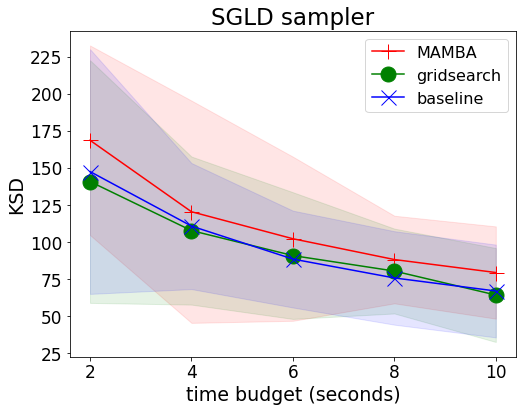

In [6]:
plt.rcParams.update({'font.size':17})

max_time_budget = 8

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sgld_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sgld_mamba+2*sd_ksd_curve_sgld_mamba, 
                 mean_ksd_curve_sgld_mamba-2*sd_ksd_curve_sgld_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sgld_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sgld_gridsearch+2*sd_ksd_curve_sgld_gridsearch, 
                 mean_ksd_curve_sgld_gridsearch-2*sd_ksd_curve_sgld_gridsearch, alpha=0.1, color='g')

plt.plot(list_time_budget, mean_ksd_curve_sgld_baseline, marker="x", markersize=15, 
         c='b', label="baseline")
plt.fill_between(list_time_budget, mean_ksd_curve_sgld_baseline+2*sd_ksd_curve_sgld_baseline, 
                 mean_ksd_curve_sgld_baseline-2*sd_ksd_curve_sgld_baseline, alpha=0.1, color='b')

plt.title("SGLD sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/sgld_ksd_curves_R1_R5_n90.png")

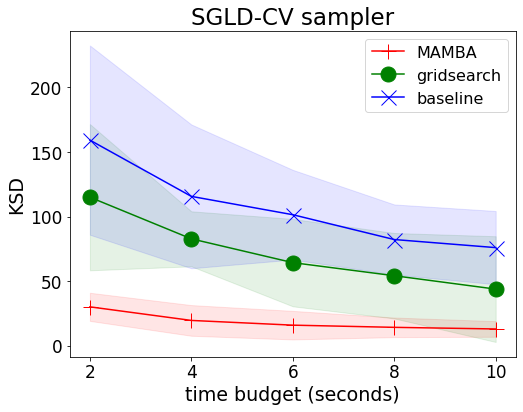

In [7]:
plt.rcParams.update({'font.size':17})

max_time_budget = 8

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sgldCV_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sgldCV_mamba+2*sd_ksd_curve_sgldCV_mamba, 
                 mean_ksd_curve_sgldCV_mamba-2*sd_ksd_curve_sgldCV_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sgldCV_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sgldCV_gridsearch+2*sd_ksd_curve_sgldCV_gridsearch, 
                 mean_ksd_curve_sgldCV_gridsearch-2*sd_ksd_curve_sgldCV_gridsearch, alpha=0.1, color='g')

plt.plot(list_time_budget, mean_ksd_curve_sgldCV_baseline, marker="x", markersize=15, 
         c='b', label="baseline")
plt.fill_between(list_time_budget, mean_ksd_curve_sgldCV_baseline+2*sd_ksd_curve_sgldCV_baseline, 
                 mean_ksd_curve_sgldCV_baseline-2*sd_ksd_curve_sgldCV_baseline, alpha=0.1, color='b')

plt.title("SGLD-CV sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/sgld_ksd_curves_R1_R5_n90.png")

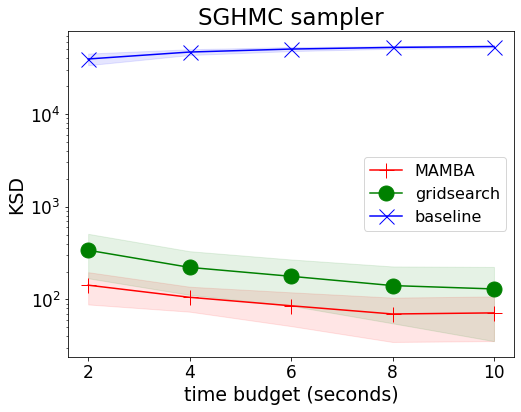

In [8]:
plt.rcParams.update({'font.size':17})

max_time_budget = 8

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sghmc_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmc_mamba+2*sd_ksd_curve_sghmc_mamba, 
                 mean_ksd_curve_sghmc_mamba-2*sd_ksd_curve_sghmc_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sghmc_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmc_gridsearch+2*sd_ksd_curve_sghmc_gridsearch, 
                 mean_ksd_curve_sghmc_gridsearch-2*sd_ksd_curve_sghmc_gridsearch, alpha=0.1, color='g')

plt.plot(list_time_budget, mean_ksd_curve_sghmc_baseline, marker="x", markersize=15, 
         c='b', label="baseline")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmc_baseline+2*sd_ksd_curve_sghmc_baseline, 
                 mean_ksd_curve_sghmc_baseline-2*sd_ksd_curve_sghmc_baseline, alpha=0.1, color='b')


plt.title("SGHMC sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.yscale("log")
plt.legend(fontsize=16)
# plt.savefig("images/sgld_ksd_curves_R1_R5_n90.png")

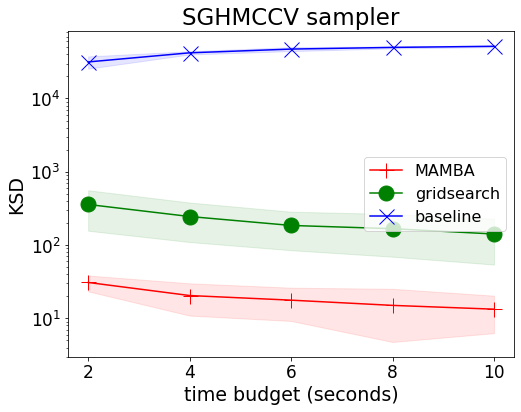

In [9]:
plt.rcParams.update({'font.size':17})

max_time_budget = 8

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sghmcCV_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmcCV_mamba+2*sd_ksd_curve_sghmcCV_mamba, 
                 mean_ksd_curve_sghmcCV_mamba-2*sd_ksd_curve_sghmcCV_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sghmcCV_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmcCV_gridsearch+2*sd_ksd_curve_sghmcCV_gridsearch, 
                 mean_ksd_curve_sghmcCV_gridsearch-2*sd_ksd_curve_sghmcCV_gridsearch, alpha=0.1, color='g')


plt.plot(list_time_budget, mean_ksd_curve_sghmcCV_baseline, marker="x", markersize=15, 
         c='b', label="baseline")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmcCV_baseline+2*sd_ksd_curve_sghmcCV_baseline, 
                 mean_ksd_curve_sghmcCV_baseline-2*sd_ksd_curve_sghmcCV_baseline, alpha=0.1, color='b')

plt.title("SGHMCCV sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.yscale("log")
plt.legend(fontsize=16)
# plt.savefig("images/sgld_ksd_curves_R1_R5_n90.png")

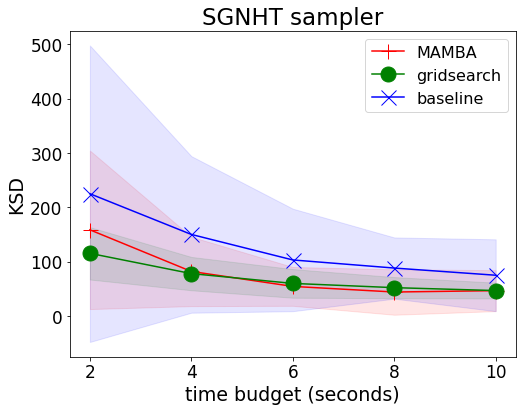

In [10]:
plt.rcParams.update({'font.size':17})

max_time_budget = 8

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sgnht_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnht_mamba+2*sd_ksd_curve_sgnht_mamba, 
                 mean_ksd_curve_sgnht_mamba-2*sd_ksd_curve_sgnht_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sgnht_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnht_gridsearch+2*sd_ksd_curve_sgnht_gridsearch, 
                 mean_ksd_curve_sgnht_gridsearch-2*sd_ksd_curve_sgnht_gridsearch, alpha=0.1, color='g')

plt.plot(list_time_budget, mean_ksd_curve_sgnht_baseline, marker="x", markersize=15, 
         c='b', label="baseline")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnht_baseline+2*sd_ksd_curve_sgnht_baseline, 
                 mean_ksd_curve_sgnht_baseline-2*sd_ksd_curve_sgnht_baseline, alpha=0.1, color='b')


plt.title("SGNHT sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/sgld_ksd_curves_R1_R5_n90.png")

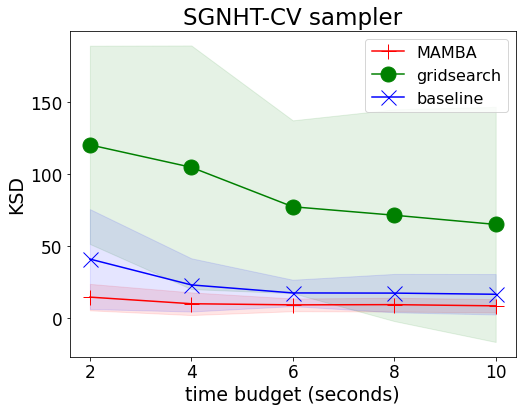

In [11]:
plt.rcParams.update({'font.size':17})

max_time_budget = 8

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sgnhtCV_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnhtCV_mamba+2*sd_ksd_curve_sgnhtCV_mamba, 
                 mean_ksd_curve_sgnhtCV_mamba-2*sd_ksd_curve_sgnhtCV_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sgnhtCV_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnhtCV_gridsearch+2*sd_ksd_curve_sgnhtCV_gridsearch, 
                 mean_ksd_curve_sgnhtCV_gridsearch-2*sd_ksd_curve_sgnhtCV_gridsearch, alpha=0.1, color='g')


plt.plot(list_time_budget, mean_ksd_curve_sgnhtCV_baseline, marker="x", markersize=15, 
         c='b', label="baseline")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnhtCV_baseline+2*sd_ksd_curve_sgnhtCV_baseline, 
                 mean_ksd_curve_sgnhtCV_baseline-2*sd_ksd_curve_sgnhtCV_baseline, alpha=0.1, color='b')


plt.title("SGNHT-CV sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/sgld_ksd_curves_R1_R5_n90.png")